In [1]:
!mkdir -p ~/.kaggle

!cp kaggle.json /root/.kaggle/

import os
for filename in os.listdir('/content'):
    print(filename)

# Set the permissions for the kaggle.json file to make it readable only by the owner
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d kaggleashwin/vehicle-type-recognition

!unzip vehicle-type-recognition.zip

.config
kaggle.json
sample_data
 90% 143M/159M [00:01<00:00, 143MB/s]
100% 159M/159M [00:01<00:00, 110MB/s]
Archive:  vehicle-type-recognition.zip
  inflating: Dataset/Bus/Image_1.jpg  
  inflating: Dataset/Bus/Image_10.jpg  
  inflating: Dataset/Bus/Image_100.jpg  
  inflating: Dataset/Bus/Image_11.jpg  
  inflating: Dataset/Bus/Image_12.jpg  
  inflating: Dataset/Bus/Image_13.jpg  
  inflating: Dataset/Bus/Image_14.jpg  
  inflating: Dataset/Bus/Image_15.jpg  
  inflating: Dataset/Bus/Image_16.jpg  
  inflating: Dataset/Bus/Image_17.jpg  
  inflating: Dataset/Bus/Image_18.jpg  
  inflating: Dataset/Bus/Image_19.jpg  
  inflating: Dataset/Bus/Image_2.jpg  
  inflating: Dataset/Bus/Image_20.jpg  
  inflating: Dataset/Bus/Image_21.jpg  
  inflating: Dataset/Bus/Image_22.jpg  
  inflating: Dataset/Bus/Image_23.jpg  
  inflating: Dataset/Bus/Image_24.png  
  inflating: Dataset/Bus/Image_25.png  
  inflating: Dataset/Bus/Image_26.jpg  
  inflating: Dataset/Bus/Image_27.jpg  
  inflating: D

In [3]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
data_dir = '/content/Dataset'
ds_name = 'Vechiles'

In [5]:
# Generate data paths with labels

def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [6]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

df.head(10)

filepaths labels
0  /content/Dataset/Truck/Image_27.jpg  Truck
1  /content/Dataset/Truck/Image_45.jpg  Truck
2  /content/Dataset/Truck/Image_40.jpg  Truck
3  /content/Dataset/Truck/Image_14.jpg  Truck
4  /content/Dataset/Truck/Image_65.jpg  Truck
5  /content/Dataset/Truck/Image_95.jpg  Truck
6  /content/Dataset/Truck/Image_68.jpg  Truck
7  /content/Dataset/Truck/Image_97.jpg  Truck
8  /content/Dataset/Truck/Image_13.JPG  Truck
9  /content/Dataset/Truck/Image_96.jpg  Truck

In [7]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

num_of_examples(df, ds_name)

The Vechiles dataset has 400 images.


In [8]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")

num_of_classes(df, ds_name)

The Vechiles dataset has 4 classes


In [9]:
def classes_count(df, name='df'):

    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)

classes_count(df, ds_name)

The Vechiles dataset has: 

Class 'Truck' has 100 images
----------------------------------------------------------------------
Class 'motorcycle' has 100 images
----------------------------------------------------------------------
Class 'Car' has 100 images
----------------------------------------------------------------------
Class 'Bus' has 100 images
----------------------------------------------------------------------


In [10]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(df,'labels')

In [11]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True,
                                      random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True,
                                     random_state= 123)

num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Vechiles dataset has 4 classes
The Validation Vechiles dataset has 4 classes
The Testing Vechiles dataset has 4 classes


In [12]:
classes_count(train_df, 'Training '+ds_name)

The Training Vechiles dataset has: 

Class 'motorcycle' has 82 images
----------------------------------------------------------------------
Class 'Car' has 74 images
----------------------------------------------------------------------
Class 'Truck' has 79 images
----------------------------------------------------------------------
Class 'Bus' has 85 images
----------------------------------------------------------------------


In [13]:
classes_count(valid_df, 'Validation '+ds_name)

The Validation Vechiles dataset has: 

Class 'Truck' has 11 images
----------------------------------------------------------------------
Class 'Car' has 21 images
----------------------------------------------------------------------
Class 'motorcycle' has 8 images
----------------------------------------------------------------------
Class 'Bus' has 8 images
----------------------------------------------------------------------


In [14]:
classes_count(test_df, 'Testing '+ds_name)

The Testing Vechiles dataset has: 

Class 'Bus' has 7 images
----------------------------------------------------------------------
Class 'motorcycle' has 10 images
----------------------------------------------------------------------
Class 'Truck' has 10 images
----------------------------------------------------------------------
Class 'Car' has 5 images
----------------------------------------------------------------------


In [15]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation,
# it just take the image and return it again.

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 320 validated image filenames belonging to 4 classes.
Found 48 validated image filenames belonging to 4 classes.
Found 32 validated image filenames belonging to 4 classes.


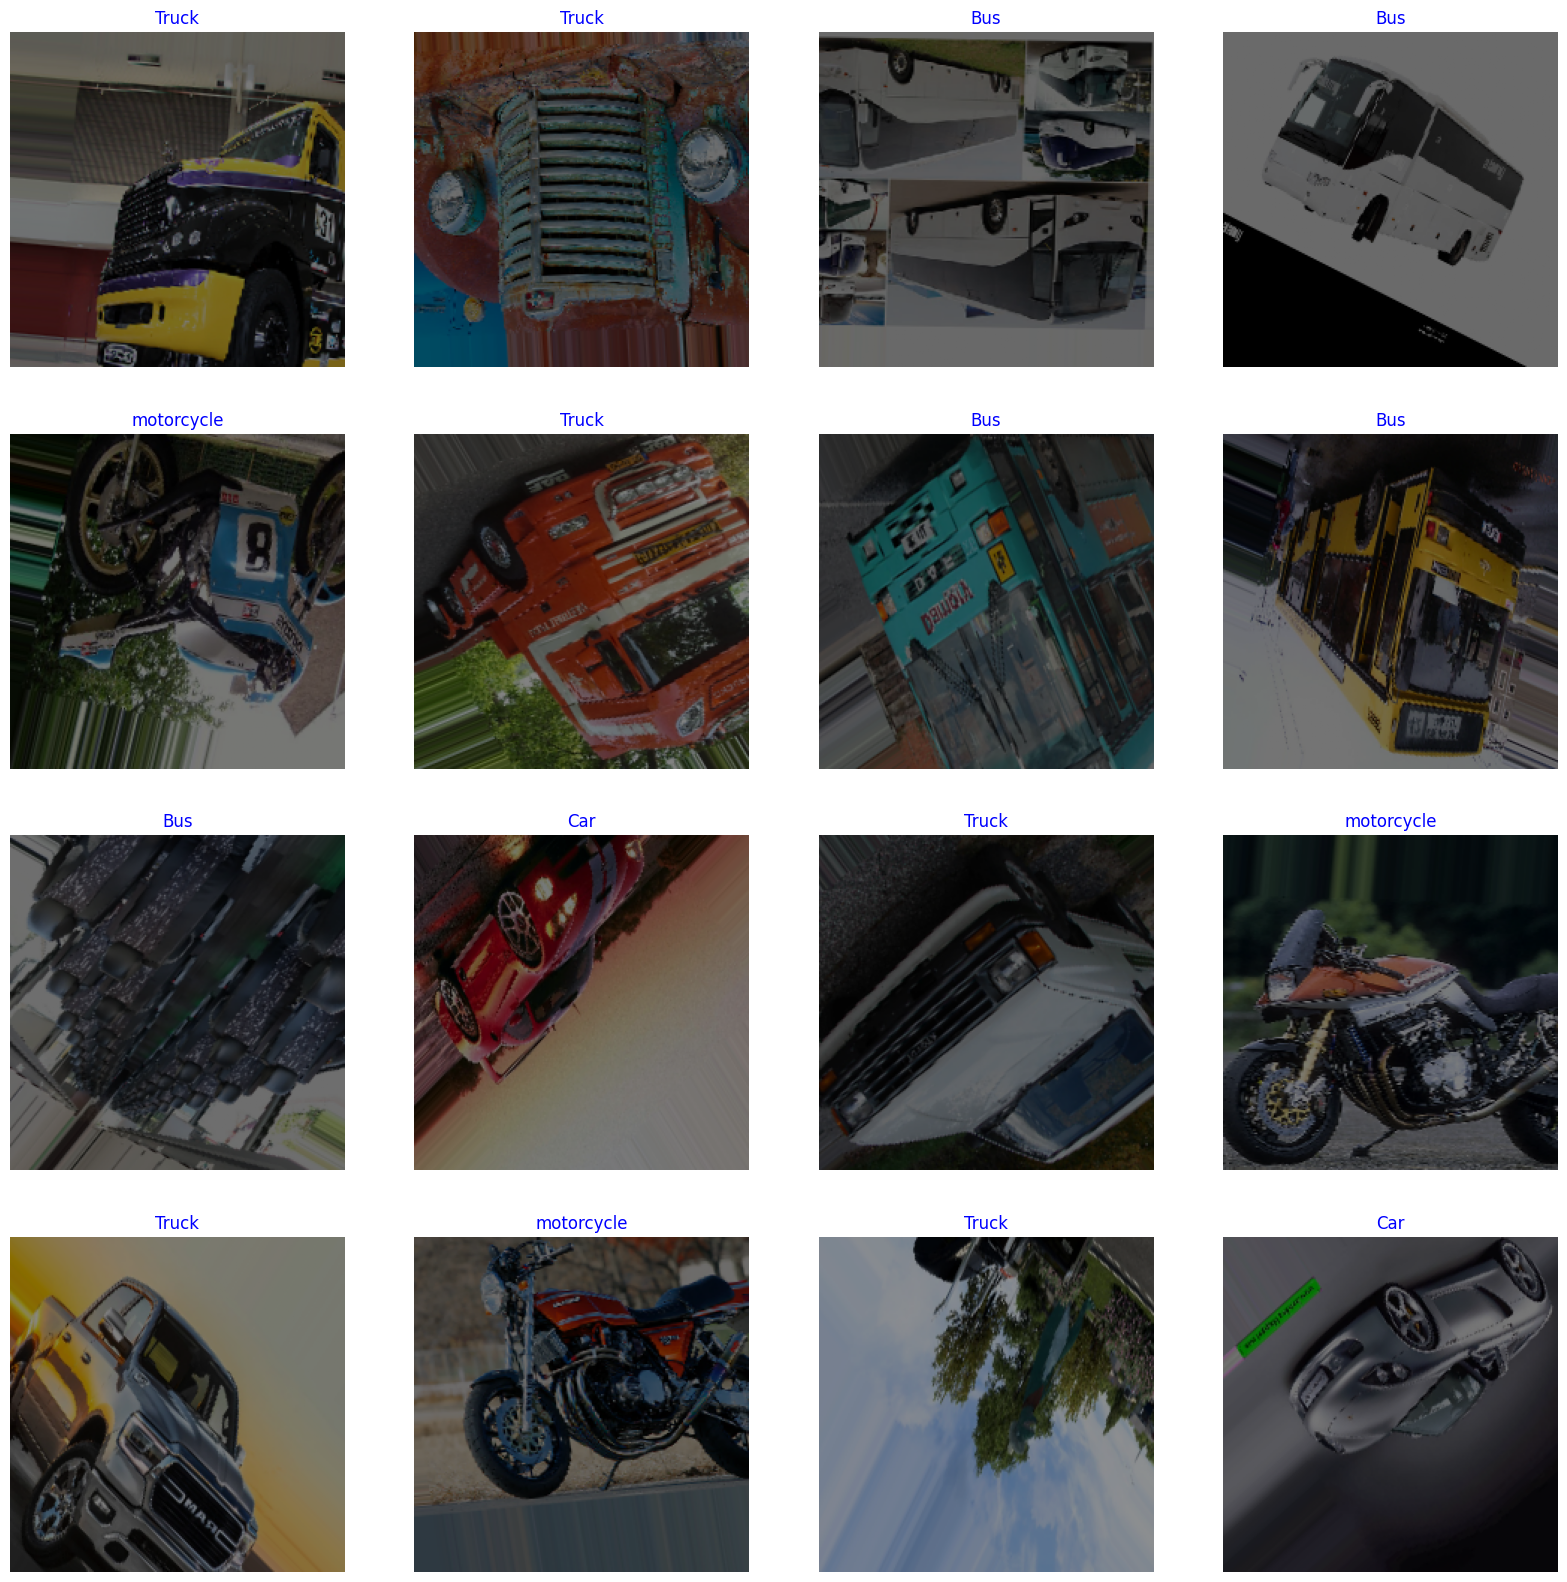

In [16]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

plt.show()

In [17]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top= False,
                                                               weights= "imagenet",
                                                               input_shape= img_shape,
                                                               pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016),
          activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

model.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 batch_normalization (BatchN  (None, 2560)             10240     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               327808    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 64,436,251
Trainable params: 333,444
Non-

In [18]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True,
                               mode='max',
                              )

def step_decay(epoch):

     initial_lrate = 0.1
     drop = 0.5
     epochs_drop = 10.0
     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
     return lrate

lr_scheduler = LearningRateScheduler(step_decay)

In [19]:
batch_size = 32   # set batch size for training
epochs = 100   # number of all epochs in training

history = model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen,
                    validation_steps= None,
                    shuffle= False,
                    batch_size= batch_size)

Epoch 1/100
20/20 [==============================] - 50s 1s/step - loss: 5.5128 - accuracy: 0.6031 - val_loss: 5.3228 - val_accuracy: 0.7708
Epoch 2/100
20/20 [==============================] - 13s 663ms/step - loss: 4.7306 - accuracy: 0.8531 - val_loss: 5.0976 - val_accuracy: 0.8750
Epoch 3/100
20/20 [==============================] - 13s 666ms/step - loss: 4.5905 - accuracy: 0.8281 - val_loss: 4.6533 - val_accuracy: 0.8125
Epoch 4/100
20/20 [==============================] - 14s 677ms/step - loss: 4.4194 - accuracy: 0.8313 - val_loss: 4.3627 - val_accuracy: 0.8958
Epoch 5/100
20/20 [==============================] - 16s 808ms/step - loss: 4.2443 - accuracy: 0.8656 - val_loss: 4.0775 - val_accuracy: 0.9375
Epoch 6/100
20/20 [==============================] - 14s 689ms/step - loss: 4.1433 - accuracy: 0.8625 - val_loss: 4.0182 - val_accuracy: 0.9167
Epoch 7/100
20/20 [==============================] - 14s 682ms/step - loss: 3.9277 - accuracy: 0.8781 - val_loss: 3.8393 - val_accuracy: 0.

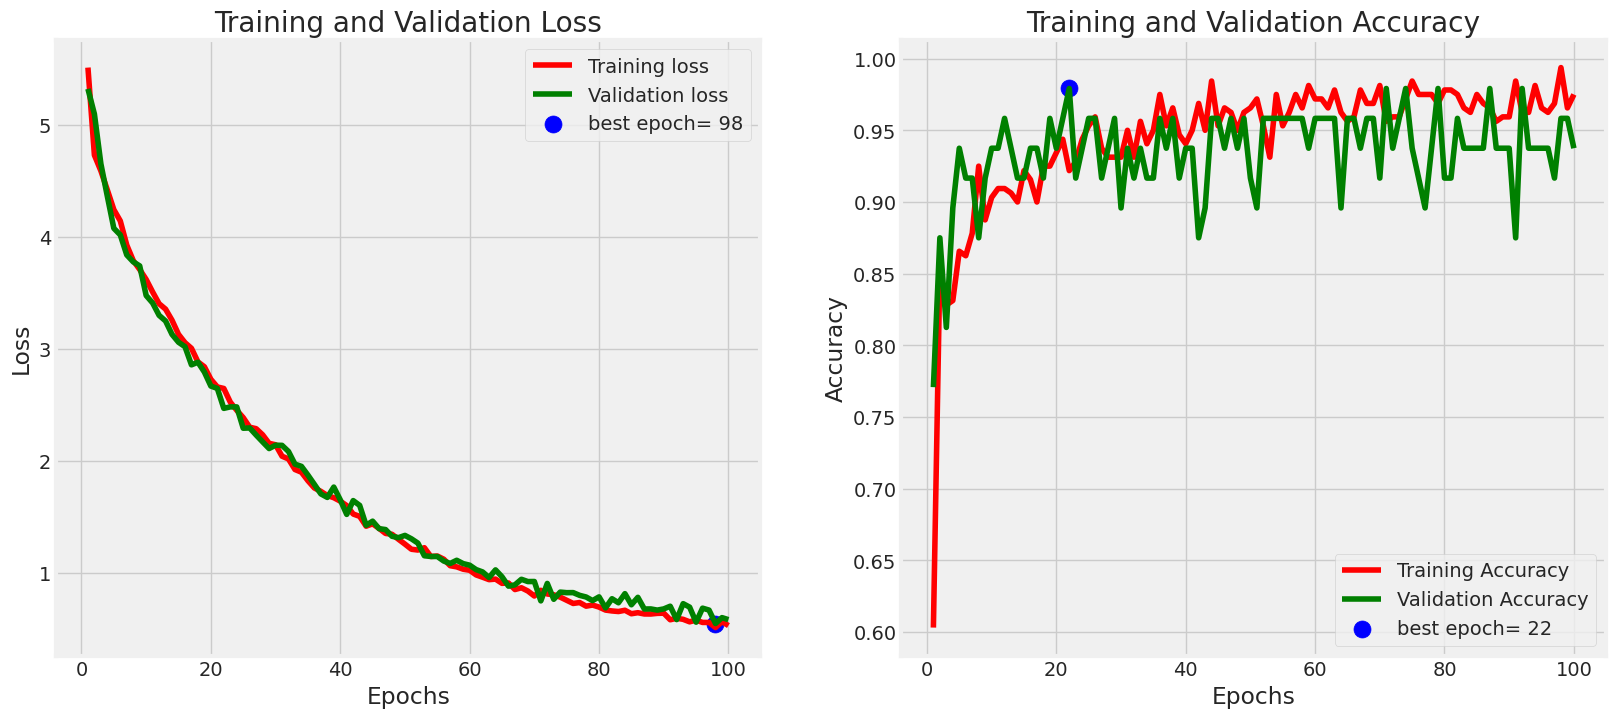

In [20]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [21]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 3s 3s/step - loss: 0.9675 - accuracy: 0.8438
Train Loss:  0.4362339377403259
Train Accuracy:  1.0
--------------------
Validation Loss:  0.784333348274231
Validation Accuracy:  0.875
--------------------
Test Loss:  0.9675283432006836
Test Accuracy:  0.84375


In [22]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

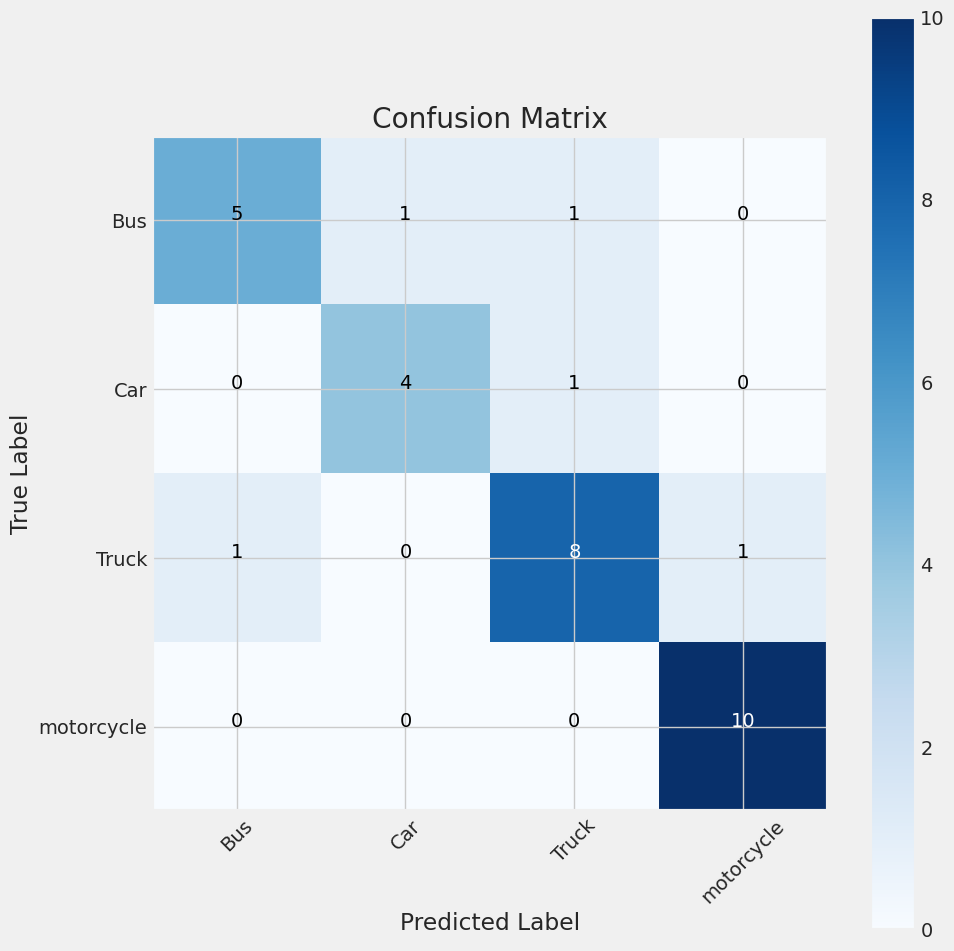

In [23]:
import itertools

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center',
             color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [24]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

         Bus       0.83      0.71      0.77         7
         Car       0.80      0.80      0.80         5
       Truck       0.80      0.80      0.80        10
  motorcycle       0.91      1.00      0.95        10

    accuracy                           0.84        32
   macro avg       0.84      0.83      0.83        32
weighted avg       0.84      0.84      0.84        32



In [25]:
model.save_weights('my_model_weights.h5')

1/1 [==============================] - 8s 8s/step


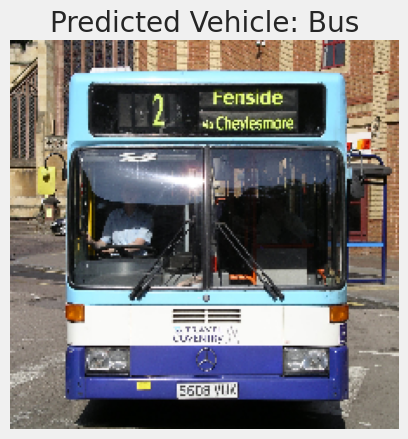

In [26]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model, class_labels):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Vehicle: {predicted_class_label}")
    plt.show()

# Load your trained model
model.load_weights('/content/my_model_weights.h5')

# Define your class labels (e.g., ['car', 'truck', ...])
class_labels = ['Bus', 'Car', 'Truck', 'Motorcycle']

# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = '/content/Dataset/Bus/Image_100.jpg'
predict_and_display(image_path_to_test, model, class_labels)

1/1 [==============================] - 0s 192ms/step


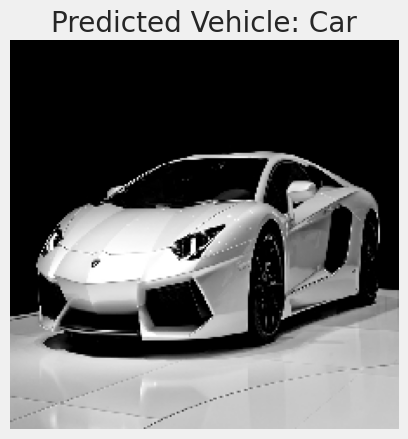

In [27]:
image_path_to_test = '/content/Dataset/Car/Image_15.jpg'
predict_and_display(image_path_to_test, model, class_labels)

1/1 [==============================] - 0s 120ms/step


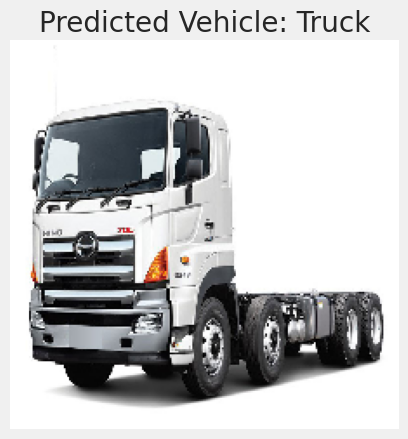

In [28]:
image_path_to_test = '/content/Dataset/Truck/Image_19.jpg'
predict_and_display(image_path_to_test, model, class_labels)

1/1 [==============================] - 0s 42ms/step


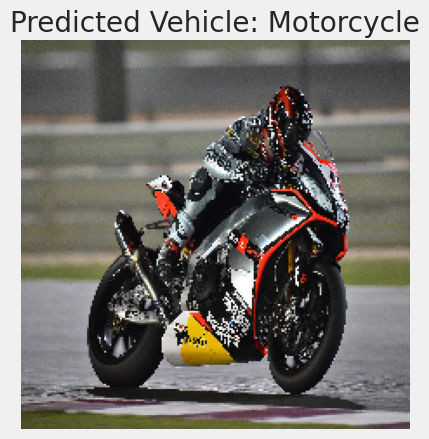

In [29]:
image_path_to_test = '/content/Dataset/motorcycle/Image_1.jpeg'
predict_and_display(image_path_to_test, model, class_labels)

Comparing models:

In [31]:
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

effnet_models = [EfficientNetB0, EfficientNetB1, EfficientNetB2,
                 EfficientNetB3, EfficientNetB4, EfficientNetB5,
                 EfficientNetB6, EfficientNetB7]
epochs = 50

for i, effnet_model in enumerate(effnet_models):
    print(f"Training and evaluating EfficientNet B{i}...")

    base_model = effnet_model(include_top=False, weights="imagenet",
                              input_shape=img_shape, pooling='max')
    base_model.trainable = False

    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l=0.016),
              activity_regularizer=tf.keras.regularizers.l1(0.006),
              bias_regularizer=tf.keras.regularizers.l1(0.006), activation='relu'),
        Dropout(rate=0.45, seed=123),
        Dense(class_count, activation='softmax')
    ])

    model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5,
                                   restore_best_weights=True, mode='max')

    history = model.fit(x=train_gen,
                        epochs=epochs,
                        verbose=0,
                        validation_data=valid_gen,
                        validation_steps=None,
                        shuffle=False,
                        callbacks=[early_stopping])

    print(f"EfficientNet B{i} training completed.")

    # Evaluate the model on the test data
    test_results = model.evaluate(test_gen, verbose=0)
    print(f"Test loss for EfficientNet B{i}: {test_results[0]}")
    print(f"Test accuracy for EfficientNet B{i}: {test_results[1]}")

    # Make predictions on the test data
    y_pred = model.predict(test_gen)
    y_pred_labels = y_pred.argmax(axis=1)
    y_true_labels = test_gen.classes

    # Generate classification report
    report = classification_report(y_true_labels, y_pred_labels,
                                   target_names=train_gen.class_indices.keys())
    print(report)
    print("-"*70)

Training and evaluating EfficientNet B0...
EfficientNet B0 training completed.
Test loss for EfficientNet B0: 4.2510151863098145
Test accuracy for EfficientNet B0: 0.78125


1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

         Bus       0.44      0.57      0.50         7
         Car       1.00      0.80      0.89         5
       Truck       0.60      0.60      0.60        10
  motorcycle       0.89      0.80      0.84        10

    accuracy                           0.69        32
   macro avg       0.73      0.69      0.71        32
weighted avg       0.72      0.69      0.70        32

----------------------------------------------------------------------
Training and evaluating EfficientNet B1...
27018416/27018416 [==============================] - 0s 0us/step
EfficientNet B1 training completed.
Test loss for EfficientNet B1: 4.67771053314209
Test accuracy for EfficientNet B1: 0.84375


1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

         Bus       0.80      0.57      0.67         7
         Car       1.00      1.00      1.00         5
       Truck       0.75      0.90      0.82        10
  motorcycle       1.00      1.00      1.00        10

    accuracy                           0.88        32
   macro avg       0.89      0.87      0.87        32
weighted avg       0.88      0.88      0.87        32

----------------------------------------------------------------------
Training and evaluating EfficientNet B2...
31790344/31790344 [==============================] - 0s 0us/step
EfficientNet B2 training completed.
Test loss for EfficientNet B2: 4.425642967224121
Test accuracy for EfficientNet B2: 0.75
1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

         Bus       0.67      0.57      0.62         7
         Car       0.75      0.60      0.67         